# Load data from kaggle

In [1]:
# Step 1: Install Kaggle CLI
!pip install --quiet kaggle

# Step 2: Upload the kaggle.json file manually (use Colab file upload)
from google.colab import files
files.upload()   # when prompted, upload the kaggle.json file

# Step 3: Move kaggle.json into the right place and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the dataset
!kaggle datasets download -d raviyadav43/drowsiness-dataset2

# Step 5: Unzip the dataset
!unzip drowsiness-dataset2.zip -d drowsiness_dataset

# Step 6: (Optional) List the files to verify
!ls -R drowsiness_dataset | head -n 50


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/raviyadav43/drowsiness-dataset2
License(s): DbCL-1.0
  0% 0.00/68.4M [00:00<?, ?B/s]
100% 68.4M/68.4M [00:00<00:00, 1.72GB/s]
Archive:  drowsiness-dataset2.zip
  inflating: drowsiness_dataset/train/Closed/_0.jpg  
  inflating: drowsiness_dataset/train/Closed/_1.jpg  
  inflating: drowsiness_dataset/train/Closed/_10.jpg  
  inflating: drowsiness_dataset/train/Closed/_100.jpg  
  inflating: drowsiness_dataset/train/Closed/_101.jpg  
  inflating: drowsiness_dataset/train/Closed/_102.jpg  
  inflating: drowsiness_dataset/train/Closed/_103.jpg  
  inflating: drowsiness_dataset/train/Closed/_104.jpg  
  inflating: drowsiness_dataset/train/Closed/_105.jpg  
  inflating: drowsiness_dataset/train/Closed/_106.jpg  
  inflating: drowsiness_dataset/train/Closed/_107.jpg  
  inflating: drowsiness_dataset/train/Closed/_108.jpg  
  inflating: drowsiness_dataset/train/Closed/_109.jpg  
  inflating: drowsiness_dataset/train/

# Import Libraries

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.models as models


# Loading images & applying transformation

In [ ]:

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [4]:
dataset_path = "/content/drowsiness_dataset/train"
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
len(dataset)

2901

In [5]:
print("Classes:", dataset.classes)
print("Class Index Map:", dataset.class_to_idx)

Classes: ['Closed', 'Open', 'no_yawn', 'yawn']
Class Index Map: {'Closed': 0, 'Open': 1, 'no_yawn': 2, 'yawn': 3}


In [6]:
train_size = int(0.80*len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(2320, 581)

In [7]:
from torch.utils.data import random_split

train_dataset, val_dataset =random_split(dataset, [train_size, val_size])

# Creating data loaders

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [9]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


# Visualising images

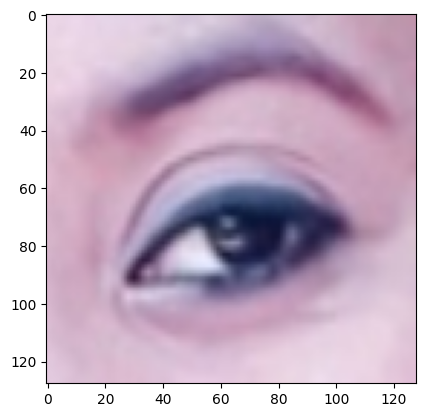

In [10]:
plt.imshow(images[7].permute(1,2,0))
plt.show()

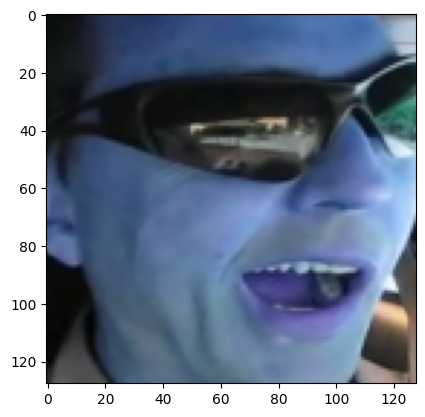

In [11]:
plt.imshow(images[11].permute(1,2,0))
plt.show()

In [12]:
num_classes = len(dataset.classes)
num_classes

4

# Defining the pretrained models

In [13]:
class Drowsiness_Detector(nn.Module):
  def __init__(self, num_classes):
     super().__init__()
     self.model = models.efficientnet_b0(weights="DEFAULT")

     for params in self.model.parameters():
      params.requires_grad = False

      in_features = self.model.classifier[1].in_features

      self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes))

  def forward(self, x):
        x = self.model(x)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
model = Drowsiness_Detector(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]


# Model training & Evaluation

In [16]:
epochs = 40
train_losses = []

for epoch in range(epochs):
  model.train()
  running_loss = 0
  total        = 0
  correct      = 0

  for images, labels in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    total += len(labels)

    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()

  accuracy = (correct / total)
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)
  print(f"Epoch : {epoch + 1}, Training Loss : {train_loss},  Accuracy : {accuracy:.2f}%")

100%|██████████| 73/73 [00:11<00:00,  6.42it/s]


Epoch : 1, Training Loss : 1.2623977007931226,  Accuracy : 0.43%


100%|██████████| 73/73 [00:06<00:00, 11.23it/s]


Epoch : 2, Training Loss : 0.9543679078964338,  Accuracy : 0.74%


100%|██████████| 73/73 [00:07<00:00, 10.39it/s]


Epoch : 3, Training Loss : 0.7668633232377979,  Accuracy : 0.81%


100%|██████████| 73/73 [00:10<00:00,  6.98it/s]


Epoch : 4, Training Loss : 0.6593273829107416,  Accuracy : 0.84%


100%|██████████| 73/73 [00:07<00:00, 10.15it/s]


Epoch : 5, Training Loss : 0.5886155611848178,  Accuracy : 0.86%


100%|██████████| 73/73 [00:06<00:00, 10.86it/s]


Epoch : 6, Training Loss : 0.5130334520993167,  Accuracy : 0.88%


100%|██████████| 73/73 [00:07<00:00,  9.71it/s]


Epoch : 7, Training Loss : 0.4794726298279958,  Accuracy : 0.88%


100%|██████████| 73/73 [00:05<00:00, 12.35it/s]


Epoch : 8, Training Loss : 0.4379283593942041,  Accuracy : 0.89%


100%|██████████| 73/73 [00:06<00:00, 11.36it/s]


Epoch : 9, Training Loss : 0.4161441893610236,  Accuracy : 0.89%


100%|██████████| 73/73 [00:05<00:00, 12.39it/s]


Epoch : 10, Training Loss : 0.38640690788830795,  Accuracy : 0.90%


100%|██████████| 73/73 [00:06<00:00, 11.50it/s]


Epoch : 11, Training Loss : 0.37430777941664606,  Accuracy : 0.91%


100%|██████████| 73/73 [00:06<00:00, 11.08it/s]


Epoch : 12, Training Loss : 0.3536104984479408,  Accuracy : 0.90%


100%|██████████| 73/73 [00:06<00:00, 11.85it/s]


Epoch : 13, Training Loss : 0.3355902929420341,  Accuracy : 0.91%


100%|██████████| 73/73 [00:07<00:00,  9.62it/s]


Epoch : 14, Training Loss : 0.3145721567003694,  Accuracy : 0.92%


100%|██████████| 73/73 [00:10<00:00,  7.04it/s]


Epoch : 15, Training Loss : 0.3112776518276293,  Accuracy : 0.92%


100%|██████████| 73/73 [00:10<00:00,  6.91it/s]


Epoch : 16, Training Loss : 0.30031389937008895,  Accuracy : 0.92%


100%|██████████| 73/73 [00:06<00:00, 11.26it/s]


Epoch : 17, Training Loss : 0.2908551615394958,  Accuracy : 0.92%


100%|██████████| 73/73 [00:09<00:00,  7.33it/s]


Epoch : 18, Training Loss : 0.28201511685978875,  Accuracy : 0.93%


100%|██████████| 73/73 [00:05<00:00, 12.33it/s]


Epoch : 19, Training Loss : 0.2663974459857157,  Accuracy : 0.93%


100%|██████████| 73/73 [00:06<00:00, 11.26it/s]


Epoch : 20, Training Loss : 0.25994385615603566,  Accuracy : 0.93%


100%|██████████| 73/73 [00:05<00:00, 12.44it/s]


Epoch : 21, Training Loss : 0.25529474836506255,  Accuracy : 0.93%


100%|██████████| 73/73 [00:06<00:00, 11.31it/s]


Epoch : 22, Training Loss : 0.24406975895574648,  Accuracy : 0.94%


100%|██████████| 73/73 [00:05<00:00, 12.44it/s]


Epoch : 23, Training Loss : 0.2511890285635648,  Accuracy : 0.93%


100%|██████████| 73/73 [00:06<00:00, 11.28it/s]


Epoch : 24, Training Loss : 0.2421110249953727,  Accuracy : 0.93%


100%|██████████| 73/73 [00:05<00:00, 12.45it/s]


Epoch : 25, Training Loss : 0.24628062852441449,  Accuracy : 0.93%


100%|██████████| 73/73 [00:06<00:00, 11.30it/s]


Epoch : 26, Training Loss : 0.23417622606231742,  Accuracy : 0.93%


100%|██████████| 73/73 [00:05<00:00, 12.48it/s]


Epoch : 27, Training Loss : 0.2292173087392768,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.35it/s]


Epoch : 28, Training Loss : 0.2203124682993105,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.51it/s]


Epoch : 29, Training Loss : 0.2225195389904388,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.17it/s]


Epoch : 30, Training Loss : 0.22237883865425032,  Accuracy : 0.93%


100%|██████████| 73/73 [00:05<00:00, 12.36it/s]


Epoch : 31, Training Loss : 0.21760359263583406,  Accuracy : 0.93%


100%|██████████| 73/73 [00:07<00:00,  9.99it/s]


Epoch : 32, Training Loss : 0.21786716958023097,  Accuracy : 0.93%


100%|██████████| 73/73 [00:06<00:00, 11.70it/s]


Epoch : 33, Training Loss : 0.204482277370479,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.19it/s]


Epoch : 34, Training Loss : 0.20401373485179797,  Accuracy : 0.94%


100%|██████████| 73/73 [00:05<00:00, 12.36it/s]


Epoch : 35, Training Loss : 0.20555528181872956,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.28it/s]


Epoch : 36, Training Loss : 0.20312882092309326,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 12.08it/s]


Epoch : 37, Training Loss : 0.19977114584347974,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.51it/s]


Epoch : 38, Training Loss : 0.19159724971611206,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.91it/s]


Epoch : 39, Training Loss : 0.19618501044707756,  Accuracy : 0.94%


100%|██████████| 73/73 [00:06<00:00, 11.81it/s]

Epoch : 40, Training Loss : 0.19953944738188836,  Accuracy : 0.94%


In [17]:

model.eval()
total = 0
correct = 0
accuracies = []
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    total += len(labels)
    correct += (preds == labels).sum().item()
    accuracies.append(correct/total)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

val_accuracy = (correct / total)
print(f"Evaluation Accuracy : {val_accuracy:.4f}%")


100%|██████████| 19/19 [00:01<00:00, 12.40it/s]

Evaluation Accuracy : 0.9639%


# Visualising training and evaluation

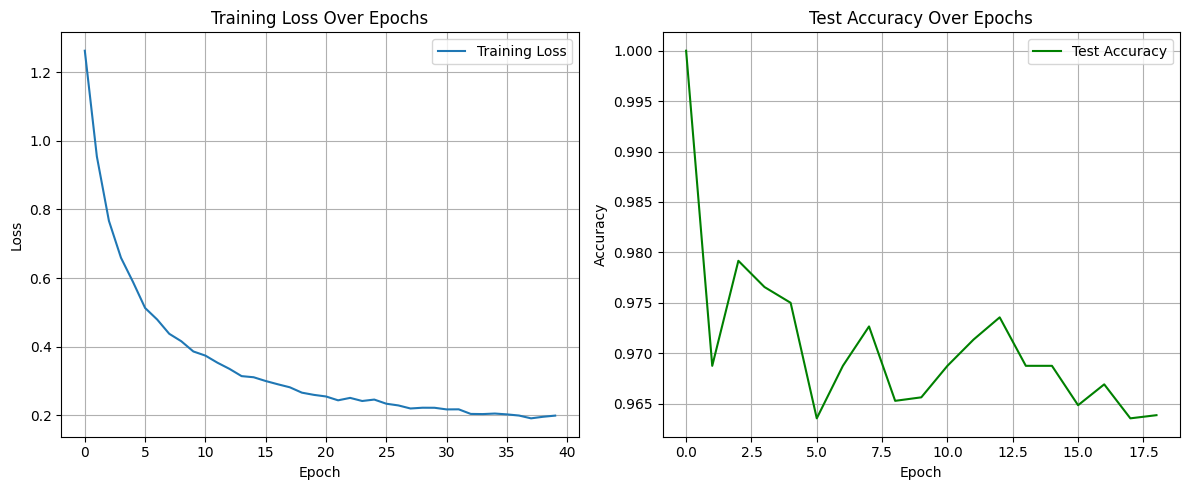

In [18]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluation with classification_report and confusion_matrix

In [23]:
class_names = dataset.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

      Closed       0.97      0.97      0.97       159
        Open       0.97      0.97      0.97       147
     no_yawn       0.94      0.95      0.95       126
        yawn       0.96      0.95      0.96       149

    accuracy                           0.96       581
   macro avg       0.96      0.96      0.96       581
weighted avg       0.96      0.96      0.96       581



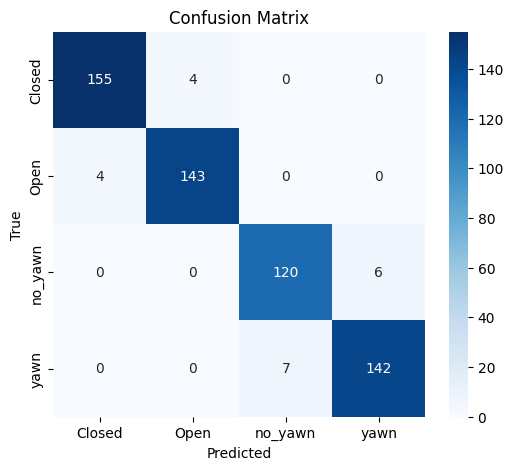

In [25]:

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Saving the model

In [26]:
torch.save(model.state_dict(), "Drowsiness_Detection_model.pth")